Files already downloaded and verified
Files already downloaded and verified
Using GPU: NVIDIA GeForce MX550
Epoch 1, Training Loss: 2.1110, Training Accuracy: 0.1807, Validation Accuracy: 0.1836
Epoch 2, Training Loss: 1.9352, Training Accuracy: 0.2109, Validation Accuracy: 0.1630
Epoch 3, Training Loss: 1.8655, Training Accuracy: 0.2266, Validation Accuracy: 0.2261
Epoch 4, Training Loss: 1.8184, Training Accuracy: 0.2516, Validation Accuracy: 0.2039
Epoch 5, Training Loss: 1.6904, Training Accuracy: 0.3131, Validation Accuracy: 0.2500
Epoch 6, Training Loss: 1.4132, Training Accuracy: 0.4429, Validation Accuracy: 0.2863
Epoch 7, Training Loss: 1.2018, Training Accuracy: 0.5486, Validation Accuracy: 0.3362
Epoch 8, Training Loss: 1.0896, Training Accuracy: 0.5984, Validation Accuracy: 0.2958
Epoch 9, Training Loss: 0.9845, Training Accuracy: 0.6456, Validation Accuracy: 0.2657
Epoch 10, Training Loss: 0.9180, Training Accuracy: 0.6742, Validation Accuracy: 0.2620
Epoch 11, Training Lo

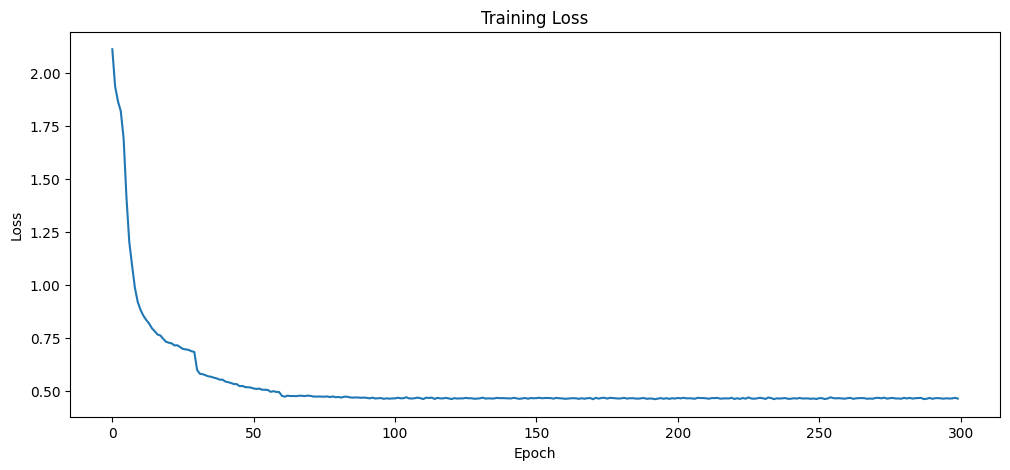

In [1]:
#------------------------------- PROBLEM 2B BN ----------------------------------#

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

# Define the ResNet Block
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(n_chans)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.constant_(self.batch_norm.weight, 0.5)
        nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        return out + x

# Define the ResNet-10 Network with Dropout and Batch Normalization
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10, n_classes=10, dropout_p=0.3):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(n_chans1)  # Batch normalization layer
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Apply batch normalization
        out = F.max_pool2d(out, 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = F.relu(self.fc1(self.dropout(out)))
        out = self.fc2(out)
        return out

# Data loading and preprocessing
data_path = '../data-unversioned/p1ch7/'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])

cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

# Model, Optimizer, and Loss Function
model = NetResDeep().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Data Loaders
train_loader = DataLoader(cifar10, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

# Training and Validation Loop
n_epochs = 300
training_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_train = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    training_losses.append(total_loss / len(train_loader))
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Scheduler step
    scheduler.step()

end_time = time.time()
training_time = end_time - start_time
print(f"Finished Training in {training_time:.2f} seconds")

# Plotting Training Loss
plt.figure(figsize=(12, 5))
plt.plot(training_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()